In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from typing import Generator, Tuple
from sklearn.preprocessing import MinMaxScaler

#FUNCIONES PROPIAS

In [2]:
def accuracy(matriz_conf:np.ndarray)->float:
  """
  Toma una matriz de confusión y devuelve la accuracy.
  PARÁMETROS:
  matriz_conf: np.array
    Matriz de confusión.
  RETURN:
  accuracy: float

  """
  tp = matriz_conf[0,0]
  tn = matriz_conf[1,1]
  fp = matriz_conf[1,0]
  fn = matriz_conf[0,1]
  return (tp+tn)/(tp+tn+fp+fn)

In [3]:
def recall(matriz_conf:np.ndarray)->float:
  """
  Toma una matriz de confusión y devuelve el recall.
  PARÁMETROS:
  matriz_conf: np.array
    Matriz de confusión.
  RETURN:
  recall: float
  """
  tp = matriz_conf[0,0]
  fn = matriz_conf[0,1]
  return tp/(tp+fn)

In [4]:
def precision(matriz_conf:np.ndarray)->float:
  """
  Toma una matriz de confusión y devuelve la precisión.
  PARÁMETROS:
  matriz_conf: np.array
    Matriz de confusión.
  RETURN:
  precision: float
  """
  tp = matriz_conf[0,0]
  fp = matriz_conf[1,0]
  return tp/(tp+fp) if (tp + fp) > 0 else 0

In [5]:
def especifidad(matriz_conf:np.ndarray)->float:
  """
  Toma una matriz de confusión y devuelve la especifidad.
  PARÁMETROS:
  matriz_conf: np.array
    Matriz de confusión.
  RETURN:
  especifidad: float
  """
  tn = matriz_conf[1,1]
  fp = matriz_conf[1,0]
  return tn/(tn+fp)

In [6]:
def skfold_manual(y:pd.DataFrame, k:int=10, random_state:int=42)-> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    """
    Implementa stratified K-Fold Cross validation en el df de clases "y"
    PARÁMETROS:
    - y: dataframe de clases
    - k: Número de folds.
    - random_state: Valor para replicabilidad
    """
    rng = np.random.default_rng(random_state)
    indices = np.arange(len(y))
    folds = [[] for _ in range(k)]
    for clase in np.unique(y):
        idxs_clase = indices[y == clase]
        rng.shuffle(idxs_clase)
        for i, idx in enumerate(idxs_clase):
            folds[i % k].append(idx)
    for i in range(k):
        test_idx = np.array(folds[i])
        train_idx = np.array([idx for j, fold in enumerate(folds) if j != i for idx in fold])
        yield train_idx, test_idx


#SECCIÓN 1:
## Tratamiento de datos

In [7]:
datos= pd.read_csv('parkinsons_data.csv').astype(float).drop(columns=["name"])
datos.head(10)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1.0
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1.0
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1.0
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1.0
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1.0
5,120.552,131.162,113.787,0.00968,0.00008,0.00463,0.00750,0.01388,0.04701,0.456,...,0.06985,0.01222,21.378,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775,1.0
6,120.267,137.244,114.820,0.00333,0.00003,0.00155,0.00202,0.00466,0.01608,0.140,...,0.02337,0.00607,24.886,0.596040,0.764112,-5.634322,0.257682,1.854785,0.211756,1.0
7,107.332,113.840,104.315,0.00290,0.00003,0.00144,0.00182,0.00431,0.01567,0.134,...,0.02487,0.00344,26.892,0.637420,0.763262,-6.167603,0.183721,2.064693,0.163755,1.0
8,95.730,132.068,91.754,0.00551,0.00006,0.00293,0.00332,0.00880,0.02093,0.191,...,0.03218,0.01070,21.812,0.615551,0.773587,-5.498678,0.327769,2.322511,0.231571,1.0
9,95.056,120.103,91.226,0.00532,0.00006,0.00268,0.00332,0.00803,0.02838,0.255,...,0.04324,0.01022,21.862,0.547037,0.798463,-5.011879,0.325996,2.432792,0.271362,1.0


status
1.0    147
0.0     48
Name: count, dtype: int64
----En proporción----
status
1.0    0.753846
0.0    0.246154
Name: proportion, dtype: float64


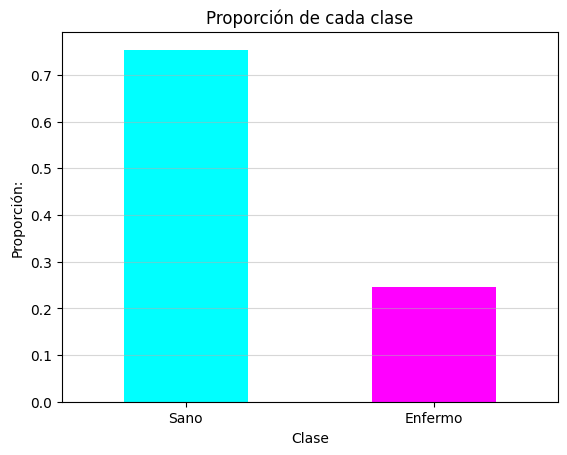

In [8]:
cantidades = datos["status"].value_counts(normalize = False)
proporciones = datos["status"].value_counts(normalize = True)
print(cantidades)
print("----En proporción----")
print(proporciones)
plt.title("Proporción de cada clase")
proporciones.plot(kind = "bar", color =["cyan", "magenta"])#, label = "Sano")
plt.xlabel("Clase")
plt.ylabel("Proporción:")
plt.xticks(np.arange(2), ["Sano", "Enfermo"], rotation = 0)
#plt.yticks(np.arange(0, 0.8, 0.05))
plt.grid(axis ="y", alpha = 0.5)
plt.show()

La proporción es 75% - 25% por lo que hay desbalanceo moderado

In [9]:
df = datos.astype(str)

# Fila que contiene al menos un "?" en alguna celda
df_con_interrogacion = df[df.apply(lambda fila: fila.str.contains(r"\?").any(), axis=1)]

# Fila que NO contiene ningún "?" en ninguna celda
df_sin_interrogacion = df[~df.apply(lambda fila: fila.str.contains(r"\?").any(), axis=1)]

print(f"Filas con '?': {len(df_con_interrogacion)}")
print(f"Filas sin '?': {len(df_sin_interrogacion)}")

Filas con '?': 0
Filas sin '?': 195


No hay '?'

#KFOLD

In [11]:
X = datos.drop(columns=["status"])
y = datos["status"]

def cross_5x2(X: pd.DataFrame, y: pd.Series, random_state: int = 42)->Tuple:
    """
    Aplica 5x2 cross-validation: 5 repeticiones de 2 folds.
    En cada repetición, se hace un train/test split 50/50, y después se  intercambian los roles.

    RETURN:
    - ac_proms: Métricas de accuracy promedio (5,)
    - rec_proms: Recall promedio (5,)
    - pres_proms: Precisión promedio (5,)
    - esp_proms: Especificidad promedio (5,)
    """
    from sklearn.model_selection import train_test_split

    accuracys = np.zeros((10, 5))
    recalls = np.zeros((10, 5))
    precisions = np.zeros((10, 5))
    especificidades = np.zeros((10, 5))

    for rep in range(5):
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, stratify=y, random_state=random_state + rep)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        for flip in range(2):
            # Si flip == 1, intercambiamos train y test
            if flip == 1:
                X_train, X_test = X_test, X_train
                y_train, y_test = y_test, y_train

            #------MODELOS------#
            #MLPDL
            mlp = MLPClassifier(
                hidden_layer_sizes=(80, 60, 40), activation='relu',
                learning_rate_init=0.01, max_iter=1000, random_state=random_state + rep)
            #MLP
            perceptron = MLPClassifier(
                hidden_layer_sizes=(100,), activation='relu',
                learning_rate='adaptive', learning_rate_init=0.01,
                max_iter=1000, random_state=random_state + rep)
            #KNNS
            knn_3 = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
            knn_5 = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
            knn_27 = KNeighborsClassifier(n_neighbors=27, metric="euclidean")

            modelos = [mlp, perceptron, knn_3, knn_5, knn_27]
            idx = rep * 2 + flip

            for j, modelo in enumerate(modelos):
                modelo.fit(X_train, y_train)
                y_pred = np.where(modelo.predict_proba(X_test)[:, 0] >= 0.1, 0, 1)
                matriz_conf = confusion_matrix(y_test, y_pred)
                accuracys[idx, j] = accuracy(matriz_conf)
                recalls[idx, j] = recall(matriz_conf)
                precisions[idx, j] = precision(matriz_conf)
                especificidades[idx, j] = especifidad(matriz_conf)

    ac_proms = np.mean(accuracys, axis=0)
    rec_proms = np.mean(recalls, axis=0)
    pres_proms = np.mean(precisions, axis=0)
    esp_proms = np.mean(especificidades, axis=0)

    return (ac_proms, rec_proms, pres_proms, esp_proms)

In [12]:
accuracys = np.zeros((30, 5))
recalls = np.zeros((30, 5))
precisions = np.zeros((30, 5))
especificidades = np.zeros((30, 5))
for i in range(30):
  accuracys[i], recalls[i], precisions[i], especificidades[i] = cross_5x2(X, y, random_state=i)

In [13]:
#mlp, perceptron, knn3, knn5, knn7
columnas = ["Accuracy", "Recall", "Precision", "Especificidad"]
tablas = []
for i in range(5):
  tabla_knn_27 = pd.DataFrame(np.array([accuracys[:, i], recalls[:, i], precisions[:, i],
                                   especificidades[:, i]]).T, columns = columnas, index = np.arange(1, 31))
  tabla_knn_27.index.name = "Corrida"
  tabla_knn_27.loc["Máx."] = tabla_knn_27.max()
  tabla_knn_27.loc["Mín."] = tabla_knn_27.min()
  tabla_knn_27.loc["Prom."] = tabla_knn_27.mean()
  tabla_knn_27.loc["Std."] = tabla_knn_27.std()
  tablas.append(tabla_knn_27)


In [14]:
print("-------------------------MLP-------------------------")
tablas[0].tail(10)

-------------------------MLP-------------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.864622,0.845833,0.690316,0.870770
26,0.860541,0.845833,0.679546,0.865346
27,0.867726,0.837500,0.689933,0.877508
28,0.875963,0.841667,0.710098,0.887134
29,0.868851,0.816667,0.702857,0.885857
30,0.867768,0.808333,0.702438,0.887171
Máx.,0.897444,0.870833,0.754991,0.906183
Mín.,0.860541,0.808333,0.679546,0.865346
Prom.,0.877322,0.839453,0.719843,0.889323


In [15]:
print("---------------------PERCEPTRON----------------------")
tablas[1].tail(10)

---------------------PERCEPTRON----------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.856449,0.875000,0.663407,0.850481
26,0.856480,0.875000,0.663528,0.850481
27,0.851325,0.862500,0.650141,0.847612
28,0.855481,0.858333,0.661757,0.854517
29,0.858563,0.854167,0.668750,0.859959
30,0.855428,0.862500,0.658986,0.853091
Máx.,0.887229,0.891667,0.730461,0.889930
Mín.,0.837976,0.829167,0.637716,0.839541
Prom.,0.859093,0.860286,0.673544,0.858829


In [16]:
print("------------------------KNN3-------------------------")
tablas[2].tail(10)

------------------------KNN3-------------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.813392,0.954167,0.576760,0.767512
26,0.819461,0.958333,0.587255,0.774176
27,0.827656,0.958333,0.599600,0.785006
28,0.828750,0.958333,0.600936,0.786468
29,0.828750,0.954167,0.601035,0.787819
30,0.833852,0.945833,0.608360,0.797316
Máx.,0.855344,0.983333,0.649756,0.831211
Mín.,0.805260,0.925000,0.569329,0.759441
Prom.,0.833723,0.954818,0.609707,0.794561


In [17]:
print("------------------------KNN5-------------------------")
tablas[3].tail(10)

------------------------KNN5-------------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.738523,0.975000,0.487697,0.661385
26,0.742594,0.975000,0.491792,0.666772
27,0.746676,0.966667,0.495952,0.674898
28,0.744698,0.966667,0.493176,0.672288
29,0.741637,0.966667,0.490492,0.668215
30,0.741616,0.962500,0.490046,0.669548
Máx.,0.764254,0.995833,0.516492,0.693854
Mín.,0.733484,0.954167,0.484593,0.653314
Prom.,0.747739,0.977083,0.497920,0.672794


In [18]:
print("------------------------KNN27-------------------------")
tablas[4].tail(10)

------------------------KNN27-------------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.560057,0.995833,0.359070,0.417771
26,0.558005,0.995833,0.357968,0.415050
27,0.570303,1.000000,0.364800,0.430007
28,0.570303,1.000000,0.364800,0.430007
29,0.570335,1.000000,0.365195,0.430063
30,0.567263,1.000000,0.363635,0.425990
Máx.,0.571292,1.000000,0.366559,0.436727
Mín.,0.546855,0.983333,0.353840,0.400333
Prom.,0.559393,0.992448,0.359350,0.418047


In [19]:
nombres = ["MLP", "Perceptron", "KNN3", "KNN5", "KNN27"]
from google.colab import files
for i in range(5):
  nombre_archivo = f"{nombres[i]}_5x2.csv"
  tablas[i].to_csv(nombre_archivo)
  files.download(nombre_archivo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>